In [1]:
! pip install pytorch-lightning==2.0.1 --quiet
! pip install lightning-bolts --quiet

In [12]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
import torchvision.transforms as T
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import seaborn as sn
import random
from torch.optim.lr_scheduler import OneCycleLR
import torch.optim as optim
from pytorch_lightning.callbacks import LearningRateMonitor

# 1- Define Model

In [6]:
class VAE(pl.LightningModule):
  def __init__(self,enc_out_dim=32, latent_dim=256, featureDim=64*24*24):

        super().__init__()

        self.save_hyperparameters()
        # encoder layers
        self.encConv1 = nn.Conv2d(2,32,3)
        self.encConv2 = nn.Conv2d(32,64,3)
        self.fc_mu = nn.Linear(featureDim,latent_dim)
        self.fc_var = nn.Linear(featureDim, latent_dim)

        # decoder layers
        self.deFC1 = nn.Linear(latent_dim + 10, featureDim)
        self.deConv1 = nn.ConvTranspose2d(64,32,3)
        self.deConv2 = nn.ConvTranspose2d(32,1,3)

        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        # classifier head layers
        self.chConv1 = nn.Conv2d(1,64,3)
        self.chout   = nn.Linear(64*26*26,10)
        # classifier loss
        self.bce_loss = nn.BCELoss(reduction = 'none')

  def encoder(self,x,y):
        # add label to image
        y = F.one_hot(y, num_classes = x.shape[2]).unsqueeze(1).unsqueeze(2) # one hot y
        y = torch.ones(x.shape).to('cuda') * y
        t = torch.cat((x,y),dim=1)
        x = F.relu(self.encConv1(t))
        x = F.relu(self.encConv2(x))
        batch_size = x.shape[0]
        x = x.view(batch_size,-1)
        return x

  def decoder(self,z,y):
        y = F.one_hot(y, num_classes = 10)
        z = torch.cat((z, y), dim=1) # b, 256 + 10
        x_hat = F.relu(self.deFC1(z))
        x_hat = x_hat.view(-1,64,24,24)
        x_hat = F.relu(self.deConv1(x_hat))
        x_hat = torch.sigmoid(self.deConv2(x_hat))
        return x_hat

  def multilabel_classifier(self,x_hat):
        x_hat_class = F.relu(self.chConv1(x_hat))
        batch_size = x_hat_class.shape[0]
        x_hat_class = x_hat_class.view(batch_size,-1)
        x_hat_class = F.sigmoid(self.chout(x_hat_class))
        return x_hat_class

  def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = OneCycleLR(
                optimizer,
                max_lr= 1E-3,
                pct_start = 5/self.trainer.max_epochs,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=len(train_dataloader),
                div_factor=100,
                three_phase=False,
                final_div_factor=100,
                anneal_strategy='linear'
            )
        return {
             "optimizer": optimizer,
             "lr_scheduler": {"scheduler": scheduler, "interval": "step"},
             }

  def kl_divergence(self,z,mu,std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

  def gaussian_likelihood(self,mean,logscale,sample):
        scale   = torch.exp(logscale)
        dist    = torch.distributions.Normal(mean,scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1,2,3))

  def forward(self,x,y,y_changed):
        # encoder
        x_encoded = self.encoder(x,y_changed)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        # decoder
        x_hat = self.decoder(z,y_changed)

        # multi label classifier
        x_multilabel = self.multilabel_classifier(x_hat)

        return x_hat,x_multilabel,z,mu,std

  def training_epoch_end(self,outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()

        print("****Training****")
        print(f'Epoch {self.current_epoch}: Train loss {loss}')
        
  def validation_epoch_end(self,outputs):
        loss = torch.stack([x for x in outputs]).mean()

        print("****Validation****")
        print(f'Epoch {self.current_epoch}: Validation loss {loss}')
        

  def mutli_label_loss(self,x_multilabel,y_combo_one_hot):
        ml_loss = self.bce_loss(x_multilabel,y_combo_one_hot).sum(dim=1)
        return ml_loss

  def training_step(self,batch,batch_idx):

        x, y, y_changed = batch['image'],batch['correct_label'],batch['changed_label']

        # forward pass thru model
        x_hat,x_multilabel,z,mu,std = self(x,y,y_changed)

        # vae loss
        recon_loss = self.gaussian_likelihood(x_hat,self.log_scale,x)
        kl = self.kl_divergence(z,mu,std)
        elbo = kl - recon_loss
        
        # combine y and y changed before sending to bce loss
        y_combo = torch.logical_or(F.one_hot(y, num_classes = 10), F.one_hot(y_changed, num_classes = 10)).float()
        ml_loss = self.mutli_label_loss(x_multilabel,y_combo)
        total_loss = (1 * ml_loss) + (0.001 * elbo)
              
        total_loss = total_loss.mean()
        
        self.log_dict({
            'elbo': (0.001 * elbo).mean(),
            'kl': kl.mean(),
            #'recon_loss': -1 * recon_loss.mean(),
            'multilabel loss':ml_loss.mean(),
            'total loss':total_loss
        })
        return total_loss
    
  def validation_step(self,batch,batch_idx):

        x, y, y_changed = batch['image'],batch['correct_label'],batch['changed_label']

        # forward pass thru model
        x_hat,x_multilabel,z,mu,std = self(x,y,y_changed)

        # vae loss
        recon_loss = self.gaussian_likelihood(x_hat,self.log_scale,x)
        kl = self.kl_divergence(z,mu,std)
        elbo = kl - recon_loss
        
        # combine y and y changed before sending to bce loss
        y_combo = torch.logical_or(F.one_hot(y, num_classes = 10), F.one_hot(y_changed, num_classes = 10)).float()
        ml_loss = self.mutli_label_loss(x_multilabel,y_combo)
        total_loss = (1 * ml_loss) + (0.001 * elbo)
              
        val_loss = total_loss.mean()
        
        return val_loss

In [4]:
# check the dimensions of the vae
my_vae_check = VAE().to('cuda')
print(my_vae_check)

x = torch.rand(1,1,28,28).to('cuda')
y = torch.tensor(1).unsqueeze(0).to('cuda')
y_changed = torch.tensor(3).unsqueeze(0).to('cuda')
x_hat,x_multiclass_out,z,mu,std = my_vae_check(x,y,y_changed)
x_multiclass_out

VAE(
  (encConv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
  (encConv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc_mu): Linear(in_features=36864, out_features=256, bias=True)
  (fc_var): Linear(in_features=36864, out_features=256, bias=True)
  (deFC1): Linear(in_features=266, out_features=36864, bias=True)
  (deConv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (deConv2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
  (chConv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (chout): Linear(in_features=43264, out_features=10, bias=True)
  (bce_loss): BCELoss()
)


tensor([[0.5088, 0.4203, 0.5331, 0.5224, 0.5259, 0.4779, 0.4880, 0.5063, 0.4731,
         0.5179]], device='cuda:0', grad_fn=<SigmoidBackward0>)

# 2 - Data

In [5]:
# function to change the labels of the target
def collate_fn(batch):
  image_list,correct_label_list,wrong_label_list = [],[],[]

  for b in batch:
    image_list.append(b[0])
    correct_label_list.append(torch.tensor(b[1]))
    if random.random() >= 0.3: # generate wrong labels 50% of the time
      wrong_label_list.append(torch.tensor(np.random.choice(np.arange(10),1)))
    else:
      wrong_label_list.append(torch.tensor(b[1]))
    
  return{
          "image": torch.vstack(image_list).unsqueeze(1),
          "correct_label": torch.vstack(correct_label_list).squeeze(1),
          "changed_label": torch.vstack(wrong_label_list).squeeze(1)
        }

transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,)),
                                  ])

dataset = MNIST(root='data',train=True,transform=transform ,download=True) # transforms.ToTensor()
train_dataloader = DataLoader(dataset = dataset, batch_size=32,shuffle=True,collate_fn=collate_fn)

dataset_test = MNIST(root='data',train=False,transform=transform, download=True) # transforms.ToTensor()
val_dataloader = DataLoader(dataset = dataset_test, batch_size=32,shuffle=False,collate_fn=collate_fn)

100%|██████████| 9912422/9912422 [00:00<00:00, 113270502.07it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72190520.75it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25008285.83it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7608038.65it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# 3 - Train Model

In [13]:
pl.seed_everything(1234)
my_vae = VAE().to('cuda')

trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=20, logger= [CSVLogger(save_dir="logs/")],
                    callbacks=[LearningRateMonitor(logging_interval="step")])
trainer.fit(my_vae,train_dataloader ,val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

****Validation****
Epoch 0: Validation loss 8.163415908813477


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 0: Validation loss 1.3629941940307617
****Training****
Epoch 0: Train loss 2.1524834632873535


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 1: Validation loss 1.3311786651611328
****Training****
Epoch 1: Train loss 1.3482739925384521


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 2: Validation loss 1.2945215702056885
****Training****
Epoch 2: Train loss 1.2846781015396118


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 3: Validation loss 1.264923334121704
****Training****
Epoch 3: Train loss 1.2440893650054932


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 4: Validation loss 1.2440366744995117
****Training****
Epoch 4: Train loss 1.2207486629486084


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 5: Validation loss 1.1783515214920044
****Training****
Epoch 5: Train loss 1.1661055088043213


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 6: Validation loss 1.148390293121338
****Training****
Epoch 6: Train loss 1.1287875175476074


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 7: Validation loss 1.1226953268051147
****Training****
Epoch 7: Train loss 1.0994470119476318


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 8: Validation loss 1.1502413749694824
****Training****
Epoch 8: Train loss 1.0763802528381348


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 9: Validation loss 1.1147665977478027
****Training****
Epoch 9: Train loss 1.0576246976852417


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 10: Validation loss 1.1046535968780518
****Training****
Epoch 10: Train loss 1.0429153442382812


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 11: Validation loss 1.1034306287765503
****Training****
Epoch 11: Train loss 1.0285704135894775


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 12: Validation loss 1.0828297138214111
****Training****
Epoch 12: Train loss 1.0215729475021362


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 13: Validation loss 1.078284502029419
****Training****
Epoch 13: Train loss 1.0082311630249023


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 14: Validation loss 1.0806478261947632
****Training****
Epoch 14: Train loss 1.0038723945617676


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 15: Validation loss 1.0692613124847412
****Training****
Epoch 15: Train loss 0.9944864511489868


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 16: Validation loss 1.0644495487213135
****Training****
Epoch 16: Train loss 0.9856837391853333


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 17: Validation loss 1.070383906364441
****Training****
Epoch 17: Train loss 0.9819890856742859


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 18: Validation loss 1.0578793287277222
****Training****
Epoch 18: Train loss 0.977859377861023


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 19: Validation loss 1.0653613805770874
****Training****
Epoch 19: Train loss 0.9749959707260132


,lr-Adam,elbo,kl,multilabel loss,total loss
epoch,,,,,
NaN,0.000015,NaN,NaN,NaN,NaN
0.0,NaN,1.217911,7.423146,4.668535,5.886446
NaN,0.000020,NaN,NaN,NaN,NaN
0.0,NaN,1.203497,6.269856,4.611849,5.815346
NaN,0.000026,NaN,NaN,NaN,NaN
...,...,...,...,...,...
5.0,NaN,1.073738,112.103439,0.118164,1.191902
NaN,0.000980,NaN,NaN,NaN,NaN
5.0,NaN,1.061624,88.762161,0.373705,1.435330


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


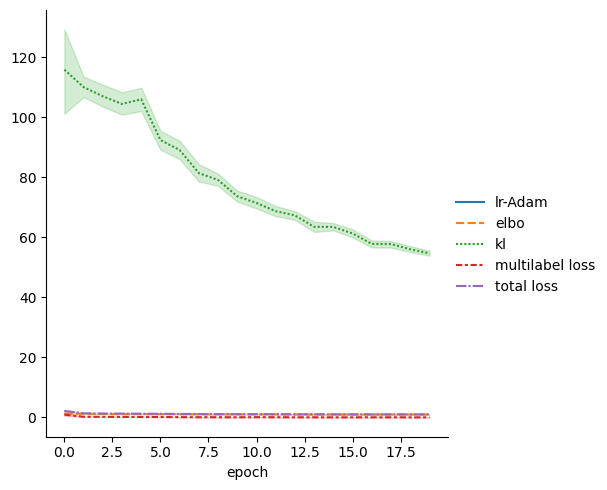

In [16]:
# training log plots
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head(400))
sn.relplot(data=metrics, kind="line")

# 4 - Plot Images

In [17]:
# plot images
def generate_image(x, y, wrong_y, model,num_predictions=25):
    figure(figsize=(8, 3), dpi=300)
    t2img = T.ToPILImage()

    with torch.no_grad():

        x_encoded   = model.encoder(x.to('cuda'),wrong_y.to('cuda'))
        mu, log_var = model.fc_mu(x_encoded), model.fc_var(x_encoded)

        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        x_hat = model.decoder(z,wrong_y.to('cuda'))

        fig = plt.figure(figsize=(10,10))

        for idx in np.arange(num_predictions):

          ax = fig.add_subplot(5,5,idx + 1,xticks=[],yticks=[])
          img = x_hat[idx].to('cpu')
          plt.imshow(img.permute(1,2,0))
          ax.set_title(f"Label/Image: {wrong_y[idx]} / {y[idx]}")

        fig.tight_layout()
        plt.show()

        #img = make_grid(x_hat, nrow=8)
        #plt.imshow(t2img(make_grid(x_hat, nrow=8)), interpolation='nearest')

<Figure size 2400x900 with 0 Axes>

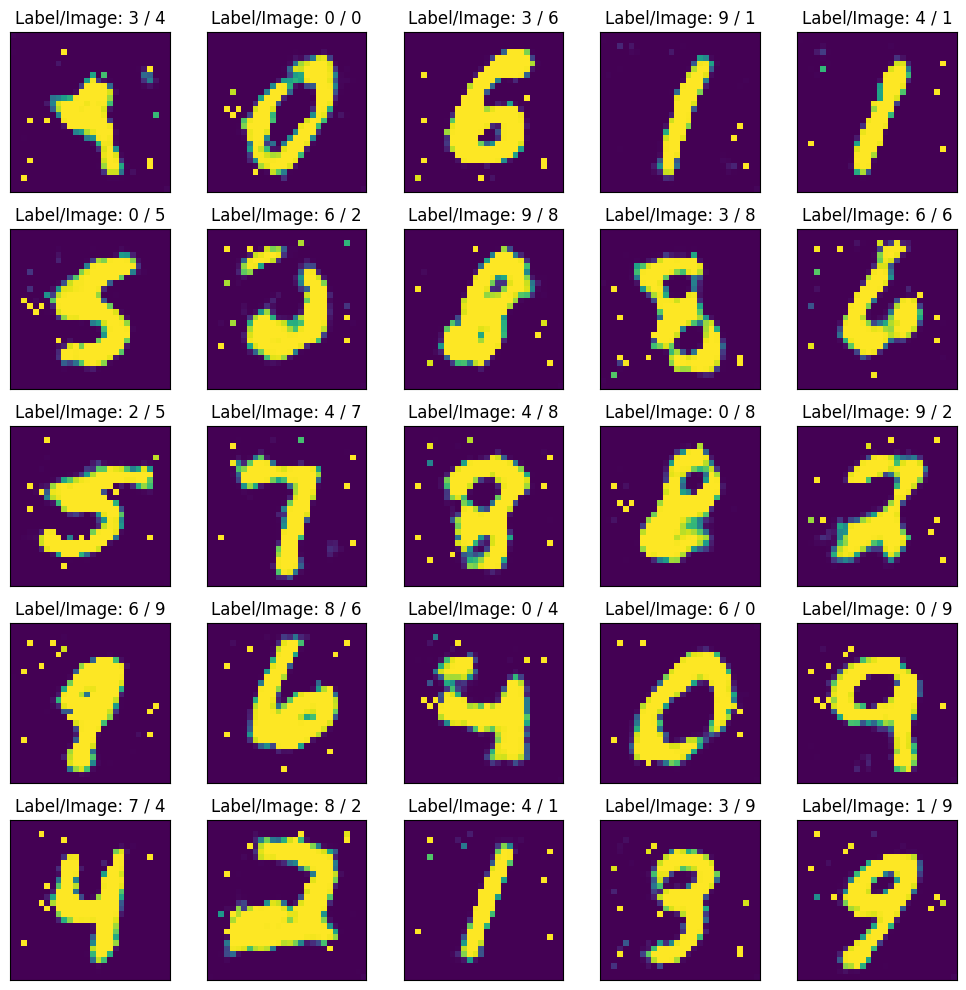

In [56]:
val_batch = next(iter(train_dataloader))
x, y, y_changed  = val_batch['image'],val_batch['correct_label'],val_batch['changed_label']
wrong_y = torch.flip(y_changed,[0])
generate_image(x,y,wrong_y,my_vae.to('cuda'))

# 0000 - NOTES

In [ ]:
# mean become -ve, so the recon losss becomes big +ve number, which causes ELBO to be -ve
# dist    = torch.distributions.Normal(3.2605e-03,0.3601)
# dist.log_prob(torch.tensor(0.0004))

In [ ]:
y = torch.tensor(9)
y_changed = torch.tensor(2)
y_combo = torch.logical_or(F.one_hot(y, num_classes = 10), F.one_hot(y_changed, num_classes = 10))
y_combo

In [ ]:
print(dataset[0][0].shape, dataset[0][1])
one_batch = next(iter(train_dataloader))
one_batch['image'].shape,one_batch['correct_label'].shape,one_batch['changed_label'].shape

In [ ]:
    # # encoder
    # x_encoded   = self.encoder(x.to('cuda'),y_changed.to('cuda'))
    # mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
    # std = torch.exp(log_var/2)
    # q = torch.distributions.Normal(mu,std)
    # z = q.rsample()
    # # decoder
    # x_hat = self.decoder(z,y_changed.to('cuda'))
    # multilabel classifier
    # x_multilabel = self.multilabel_classifier(x_hat)

    # recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    # kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    # elbo = kl + recon_loss
    # elbo = elbo.mean()

    # # vae loss
    # recon_loss = self.gaussian_likelihood(x_hat,self.log_scale,x)
    # kl = self.kl_divergence(z,mu,std)
    # elbo = kl - recon_loss
    # elbo = elbo.mean()
    # print(f"elbo {elbo}")

    # multi label classifier loss
    # y_combo = torch.logical_or(F.one_hot(y, num_classes = 10), F.one_hot(y_changed, num_classes = 10)).float()
    # print(y_combo)
    # class_loss = self.mutli_label_loss(x_multilabel,y_combo)
    # print(f"class loss {class_loss}")
